In [27]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import integrate, optimize
import time
from tqdm import tqdm
from matplotlib import animation
from IPython.display import HTML

In [28]:
%matplotlib inline

# Cellular Automata S.I.R. Model

### Description

Based on the reference [paper](https://www.math.uh.edu/~zpkilpat/teaching/math4309/project/physa99_fuentes.pdf), the aim of the project is to simulate and then study the evolution of Susceptible-Infected-Removed populations over space and time.

### Assignments
1. Consider a grid of a given form (squared or exagonal or whatever) and then let propagate the SIR model. 
2. Repeat point 1 several times in order to obtain several reference datasets
3. Try to predict the evolution of the epidemic both in space and time on the basis of the previous steps, e.g. by means of 
4. Define a metric on how the epidemic evolved e.g. assigning a probability for a given node not to get infected or predict the fraction of the nodes that got infected at the end of the epidemic

### Contacts
* Leonardo Badia <badia@dei.unipd.it>

In [55]:
def draw_line(mat, point1, point2):
    
    # function that tries to draw the best possible line made of 0s between two points point1, point2
    
    x0, y0 = point1[0], point1[1];
    x1, y1 = point2[0], point2[1];
    if not (0 <= x0 < mat.shape[0] and 0 <= x1 < mat.shape[0] and
            0 <= y0 < mat.shape[1] and 0 <= y1 < mat.shape[1]):
        raise ValueError('Invalid coordinates.')
        
    if (x0, y0) == (x1, y1):
        mat[x0, y0] = 0
        return mat
    
    # Swap axes if Y slope is smaller than X slope
    transpose = abs(x1 - x0) < abs(y1 - y0)
    if transpose:
        mat = mat.T
        x0, y0, x1, y1 = y0, x0, y1, x1
        
    # Swap line direction to go left-to-right if necessary
    if x0 > x1:
        x0, y0, x1, y1 = x1, y1, x0, y0
        
    # Compute intermediate coordinates using line equation
    x = np.arange(x0 + 1, x1)
    y = np.round(((y1 - y0) / (x1 - x0)) * (x - x0) + y0).astype(x.dtype)
    
    # Write intermediate coordinates
    mat[x, y] = 0

    return mat if not transpose else mat.T

    
def new_population(N, n):
    
    # function that generates a new population. A population is a matrix NxN containing 2 everywhere except
    # inside a figure of n vertices where there are all 0s.
    
    from numpy import pi, floor, ceil, cos, sin;
    
    if n < 3: raise Exception('The number of vertices must be greater than 2.');
    
    if N%2 == 0: N+=1
        
    M = np.ones((N,N), dtype=int)+1 # matrix of 2s

    center = [floor(N/2), floor(N/2)]
    radius = floor(N/2)
    angle = 2*pi/n
    
    vertices = np.zeros((n+1,2), dtype=int)
    for vertex in range(n): # for each vertex of the polygon
        x = int(floor(center[0] + radius*cos(vertex*angle))) # x coord of the vertex of the polygon
        y = int(floor(center[1] - radius*sin(vertex*angle))) # y coord of the vertex of the polygon
        M[x,y] = 0 # set to 0 the coordinate of the population matrix
        vertices[vertex] = [x,y] # list of coordinates of the vertices of the polygon
    vertices[n] = vertices[0] # add the first vertex at the end so that is a closed polygon

    for i in range(1,len(vertices)):
        M = draw_line(M, vertices[i-1], vertices[i]) # trace the edges of the polygon
            
       
    for row in range(N): # the polygon is filled with 0s for each row
        row_i = M[row,:]   
        x1 = np.argwhere(M[row,:]==0)
        x2 = np.argwhere(M[row,:]==0)
        if len(x1)==0 or len(x2)==0: continue;
        x1, x2 = min(x1), max(x2)
        if x1==0 and x2==0: continue;
        M = draw_line(M, [row, x1], [row, x2])
          
    return M;

def inizialization(population, infected, random=False):
    """
        Inizialization for patients zero, if random = True takes 10 random points else takes coordinates
    """
    centered = True
    if not random:
        for coord in infected:
            if population[coord] == 2 : raise Exception('Bad inizialization, outside polygon');
            population[coord] = 1 # the people located at "infected" are turned into infected: 0 -> 1
    else:
        #we grab the indexes of the ones
        if centered:
            x,y = np.where(population == 0)
        #we chose one index randomly
        i = np.random.randint(len(x),size=10)
        for randnr in i:
            coord = (x[i],y[i])
            population[coord] = 1
    return population
####################################################################################################################




# 0 = S , 1 = I , -1 = R
p_i = 0.5 # probability of infection
p_r = 0.005 # probability of recovery

cycles=50 # maximum number of cycles
experiments = 3 #nr of experiments
df_experiments = pd.DataFrame(columns = ['EXP','S','I','R'])
spatialLogs = False
for exp in tqdm(range(experiments)):
    resolution, polygon_sides = 100, 50 # resolution is in reality the number of people inside the outward matrix
    population = new_population(resolution, polygon_sides); # population is a matrix of 2 if outside the figure while 0 if inside the figure
    population_time = np.zeros(population.shape)-1

    center = int(np.floor(resolution/2)) # just to keep track of where the center is

    infected = [(center,center), (center-30,center-30)] # initialization of where Infected are. Can be tuple or list of tuples
    population = inizialization(population, infected, random=True)
    S=[]; I=[]; R=[]; 
    if spatialLogs: matrices = [];
    for cycle in range(cycles):
        s,i,r=0,0,0
        for index,value in np.ndenumerate(population):
            if population_time[index]==cycle:pass #already processed
            elif value==2:pass #not in the region space
            elif value==1: #infect detected
                i+=1
                #cicle the neighbors for infection
                for j in range(-1,2):
                    for k in range(-1,2):
                        if 0<=index[0]+j<population.shape[0] and 0<=index[1]+k<population.shape[1]:
                            if population[index[0]+j,index[1]+k]==0 and np.random.choice([1, 0], p=[p_i, 1-p_i]): #element get infected
                                population[index[0]+j,index[1]+k]=1
                                population_time[index[0]+j,index[1]+k]=cycle #mark as infected in this cicle
                                if j==1 or (j==0 and k==1): s+=1 #the item will not be counted otherwise
                #infected may recovers
                if np.random.choice([1, 0], p=[p_r*(cycle-population_time[index]), 1-p_r*(cycle-population_time[index])]):
                    population[index]=-1
                    population_time[index]=cycle
            elif value==0: s+=1
            elif value==-1: r+=1
        if spatialLogs: matrices.append(population.flatten())
        S.append(s) # number of S in cycle
        I.append(i) # number of I in cycle
        R.append(r) # number of R in cycle
        if i==0:break


    if spatialLogs: df = pd.DataFrame(matrices)
    s,i,r=0,0,0
    for index,value in np.ndenumerate(population):
        if value==1: i+=1
        elif value==0: s+=1
        elif value==-1: r+=1
    S.append(s) # number of S in last cycle
    I.append(i) # number of I in last cycle
    R.append(r) # number of R in last cycle
    expnr_array = exp*np.ones(max(len(S),len(I), len(R)))
    df_exp = pd.DataFrame(np.array([expnr_array, S, I, R]).transpose(), columns=['EXP','S','I','R'])
    df_experiments = df_experiments.append(df_exp, ignore_index=True) # costoso ma ce ne faremo una ragione

100%|██████████| 3/3 [00:19<00:00,  6.40s/it]


In [56]:
df_experiments

,EXP,S,I,R
0,0.0,7977.0,10.0,0.0
1,0.0,7944.0,43.0,0.0
2,0.0,7857.0,130.0,0.0
3,0.0,7700.0,286.0,1.0
4,0.0,7499.0,486.0,2.0
...,...,...,...,...
148,2.0,41.0,1287.0,6659.0
149,2.0,27.0,1191.0,6769.0
150,2.0,16.0,1085.0,6886.0
151,2.0,6.0,984.0,6997.0


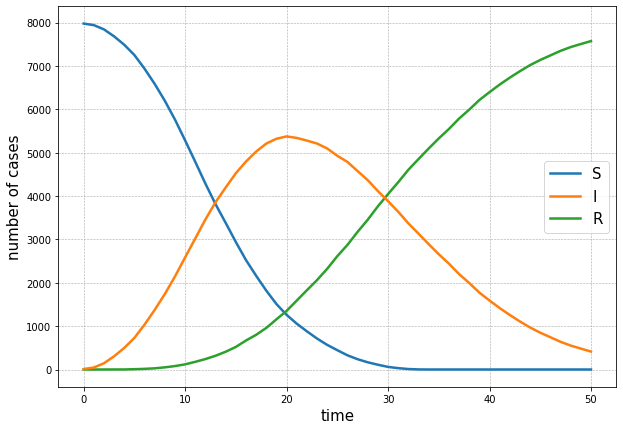

In [53]:
# graph of the number of cases for each cycle
fig2 = plt.figure(figsize = (10,7))
plt.plot(S, label='S', zorder=10, linewidth=2.5);
plt.plot(I, label='I', zorder=20, linewidth=2.5);
plt.plot(R, label='R', zorder=10, linewidth=2.5);
plt.xlabel('time', fontsize=15);
plt.ylabel('number of cases', fontsize=15);
plt.legend(fontsize=15);
plt.grid(linestyle="--", linewidth=0.6, zorder=-10);
#plt.axvline(x=np.argwhere(I==max(I)), linestyle='--', zorder=-5, linewidth=1);
#plt.xlim([0, cycles]);

## Time prediction -> fit data with SIR Model

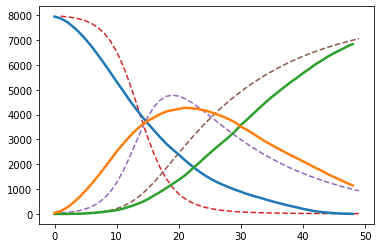

In [6]:
ydata = np.array(I[1:30])/8000
xdata = np.arange(1,30)

def sir_model(y, x, _lambda, gamma):
    S = -_lambda * y[0] * y[1] / N
    R = gamma * y[1]
    I = -(S + R)
    return S, I, R

def fit_odeint(x, _lambda, gamma):
    return integrate.odeint(sir_model, (S0, I0, R0), x, args=(_lambda, gamma))[:,1]

def fitted_odeint(x, _lambda,gamma):
    return integrate.odeint(sir_model, (S0, I0, R0), x, args=(_lambda, gamma))
N = 1.0
I0 = ydata[0]
S0 = N - I0
R0 = 0.0

popt, pcov = optimize.curve_fit(fit_odeint, xdata, ydata)

xdata = np.arange(1,50)
fitted = fitted_odeint(xdata, *popt)
fitted_S = fitted[:,0]*8000
fitted_I = fitted[:,1]*8000
fitted_R = fitted[:,2]*8000
plt.plot(np.array(S[1:50]), label='S', zorder=10, linewidth=2.5);
plt.plot(np.array(I[1:50]), label='I', zorder=20, linewidth=2.5);
plt.plot(np.array(R[1:50]), label='R', zorder=10, linewidth=2.5);
plt.plot(xdata, fitted_S, '--')
plt.plot(xdata, fitted_I, '--')
plt.plot(xdata, fitted_R, '--')
plt.show()

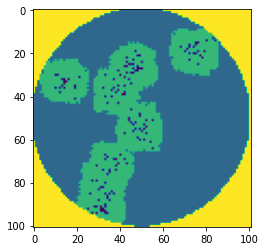

In [7]:
data = df.T[10].to_numpy().reshape(101,101) #our original matrix was a 101x101
plt.imshow(data)
plt.show()

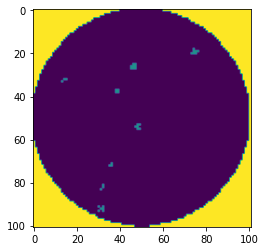

In [8]:
from matplotlib import animation  
import matplotlib.image as mgimg

#set up the figure
fig = plt.figure()
ax = plt.gca()

#initialization of animation, plot array of zeros 
def init():
    imobj.set_data(df.T[0].to_numpy().reshape(101,101))

    return  imobj,

def animate(i):
    imobj.set_data(df.T[i].to_numpy().reshape(101,101))

    return  imobj,


## create an AxesImage object
imobj = ax.imshow(df.T[0].to_numpy().reshape(101,101))#, origin='lower', alpha=1.0, zorder=1, aspect=1 )


anim = animation.FuncAnimation(fig, animate, init_func=init, repeat = True,
                               frames=range(0,49), interval=200, blit=True, repeat_delay=1000)

In [9]:
HTML(anim.to_html5_video())